# Creating an XGBoost model for predicting ESG ratings of the companies based on stock prices and news titles for the company

# Importing the libraries and loading the data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("/content/drive/MyDrive/vnp-project/data/data_with_esg.csv")

Upon further review, we discovered that the data for 'Samsung' is denominated in a different currency compared to the other companies. To ensure consistency in the analysis, we decided to omit Samsung's data.

In [3]:
data = data[~data['company'].str.contains('Samsung')]

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

This section of the code generates TF-IDF (Term Frequency-Inverse Document Frequency) features from the 'Title' column of the dataset. TF-IDF is used to quantify the importance of words in a text document based on their frequency in a document and across the entire dataset.

This technique helps the model understand textual data, such as news titles, and how they may relate to the target variable.

In [5]:
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(data['title']).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1).drop(columns=['title'])

- The 30-day rolling standard deviation (volatility) of the 'Close' price is calculated using a rolling window of 30 days. This captures the historical variability of the stock price.
- The percentage change in the 'Close' price from one day to the next is calculated as the daily return. This helps capture price movements.

In [6]:
data['volatility'] = data['Close'].rolling(window=30).std()
data['returns'] = data['Close'].pct_change()

<ipython-input-6-1c6bbf6718d3>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['returns'] = data['Close'].pct_change()


In [7]:
data.fillna(0, inplace=True)


This section of code creates a dictionary `label_mapping` that standardizes and converts text-based
labels into numerical values. The mapping is applied to multiple label columns, ensuring consistency
across different label formats (e.g., 'positive', 'POSITIVE', 'Positive' are all mapped to 1).

In [8]:
label_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': 1,
    'NEGATIVE': -1,
    'NEUTRAL': 0,
    'POSITIVE': 1,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'social': 1,
    'environment': 2,
    'government': 3
}

In [9]:
data['label_x'] = data['label_x'].map(label_mapping)
data['label_y'] = data['label_y'].map(label_mapping)
data['label_z'] = data['label_z'].map(label_mapping)
data['zero_shot_label'] = data['zero_shot_label'].map(label_mapping)
data

,Unnamed: 0.1,Unnamed: 0,company,source,time,url,label_x,score_x,label_y,score_y,...,us,visa,walmart,what,will,with,year,you,volatility,returns
0,0.0,1.0,Tesla,CNN,Apr 2,https://www.cnn.com/2024/04/02/business/tesla-...,-1.0,0.961334,-1.0,0.998681,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,1.0,2.0,Tesla,The Associated Press,Feb 2,https://apnews.com/article/tesla-recall-icons-...,-1.0,0.998407,-1.0,0.677842,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.127708
2,2.0,3.0,Tesla,samsung.com,Jan 5,https://news.samsung.com/global/samsung-announ...,1.0,0.990341,0.0,0.997251,...,0.0,0.0,0.0,0.000000,0.0,0.346546,0.0,0.0,0.0,0.263850
3,3.0,4.0,Tesla,TESLARATI,Feb 13,https://www.teslarati.com/tesla-model-3-highla...,-1.0,0.991584,1.0,0.993647,...,0.0,0.0,0.0,0.478813,0.0,0.000000,0.0,0.0,0.0,-0.225146
4,4.0,5.0,Tesla,The Associated Press,Apr 23,https://apnews.com/article/tesla-future-sales-...,-1.0,0.816990,-1.0,0.855613,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.213781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,0.0,0.0,0,0,0,0,NaN,0.000000,NaN,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2720,0.0,0.0,0,0,0,0,NaN,0.000000,NaN,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2721,0.0,0.0,0,0,0,0,NaN,0.000000,NaN,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2722,0.0,0.0,0,0,0,0,NaN,0.000000,NaN,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


This section computes new coefficient columns by multiplying the mapped labels (`label_x`, `label_y`, `label_z`, `zero_shot_label`)
with their corresponding scores (`score_x`, `score_y`, `score_z`, `zero_shot_score`). The resulting coefficients represent the
weighted impact of each label.

In [10]:
data["coef_x"] = data["label_x"] * data["score_x"]
data["coef_y"] = data["label_y"] * data["score_y"]
data["coef_z"] = data["label_z"] * data["score_z"]
data['coef_zero_shot'] = data['zero_shot_label'] * data['zero_shot_score']
data = data.drop(columns=['label_x', 'label_y', 'label_z', 'score_x', 'score_y', 'score_z', 'zero_shot_label', 'zero_shot_score'])

This section standardizes the features in the dataset to have a mean of 0 and a standard deviation of 1.
The `StandardScaler` is applied to all numerical columns while excluding non-relevant columns (e.g.,
company identifiers and dates).

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop(columns=['ESG Rating', 'company', 'url', 'source', 'time', 'Date', 'ticker', 'environmentScore', 'socialScore', 'governanceScore', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1']))
data_df_scaled = pd.DataFrame(scaled_features, columns=data.columns.drop(['ESG Rating', 'company', 'url', 'source', 'time', 'Date', 'ticker', 'environmentScore', 'socialScore', 'governanceScore', 'Unnamed: 0', 'Company Name', 'Ticker', 'Unnamed: 0.1']))

This section prepares the data for training a machine learning model by splitting the dataset into features
(X) and target variable (y). The features are derived from the scaled DataFrame, while the target variable
is the 'Close' price from the original dataset.


In [12]:
X = data_df_scaled
y = data['ESG Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the model

This section initializes an XGBoost regression model using `XGBRegressor`. The model is set to optimize
for regression tasks with the objective function defined as 'reg:squarederror', which minimizes the
squared differences between predicted and actual values.

In [13]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

This section defines a parameter grid for tuning the XGBoost model. The `param_grid` dictionary specifies
various hyperparameters and their respective values to explore during the tuning process.

Hyperparameters included:
1. `n_estimators`: Number of trees in the ensemble (100, 200).
2. `learning_rate`: Step size shrinkage to prevent overfitting (0.01, 0.1).
3. `max_depth`: Maximum depth of the trees (3, 5, 7).
4. `subsample`: Proportion of samples used for fitting the individual base learners (0.8, 1).
5. `colsample_bytree`: Proportion of features used for each tree (0.8, 1).

In [14]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

This section performs hyperparameter tuning for the XGBoost model using `GridSearchCV`. The grid search
explores the defined parameter grid to find the best combination of hyperparameters based on cross-validation.

Steps performed:
1. Initialize `GridSearchCV` with the following parameters:
   - `estimator`: The XGBoost regression model.
   - `param_grid`: The dictionary of hyperparameters to explore.
   - `cv`: Number of cross-validation folds (3).
   - `scoring`: Metric used for evaluation (negative mean squared error).
   - `verbose`: Controls the verbosity of the output (set to 1 for detailed logs).
   - `error_score`: Defines the behavior when a fit fails (set to "raise" to throw an error).

2. Fit the grid search to the training data (`X_train`, `y_train`).

In [15]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [16]:
best_xgb = grid_search.best_estimator_

In [17]:
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

1. **Mean Squared Error (MSE): 5.13**
   - This MSE indicates a relatively low average error between the predicted and actual values, suggesting that the model is performing reasonably well in this context. The value is manageable, indicating good predictive accuracy relative to the scale of the target variable.

2. **R-squared (R²): 0.9133**
   - An R-squared value of 0.9133 signifies that approximately 91.33% of the variance in the target variable is explained by the model. This suggests a strong fit, as the model captures a significant amount of the underlying relationship.

In [18]:
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 5.131499600148277
R-squared: 0.9133447238996603


# Evaluating the model

In [19]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.9 MB/s eta 0:00:00


In [20]:
import shap

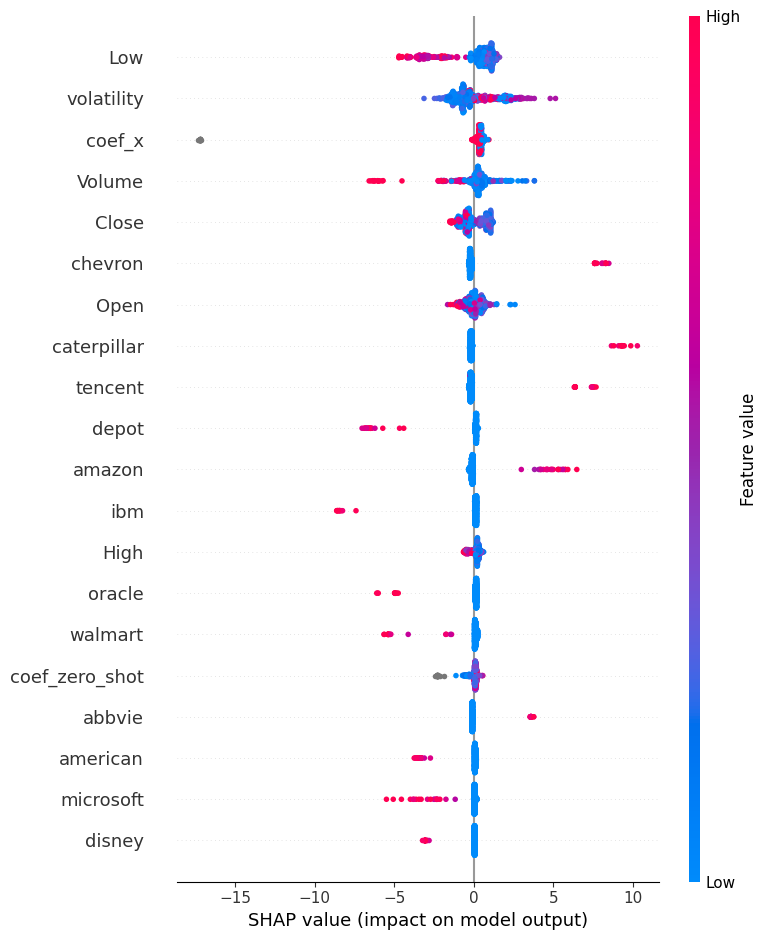

In [21]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

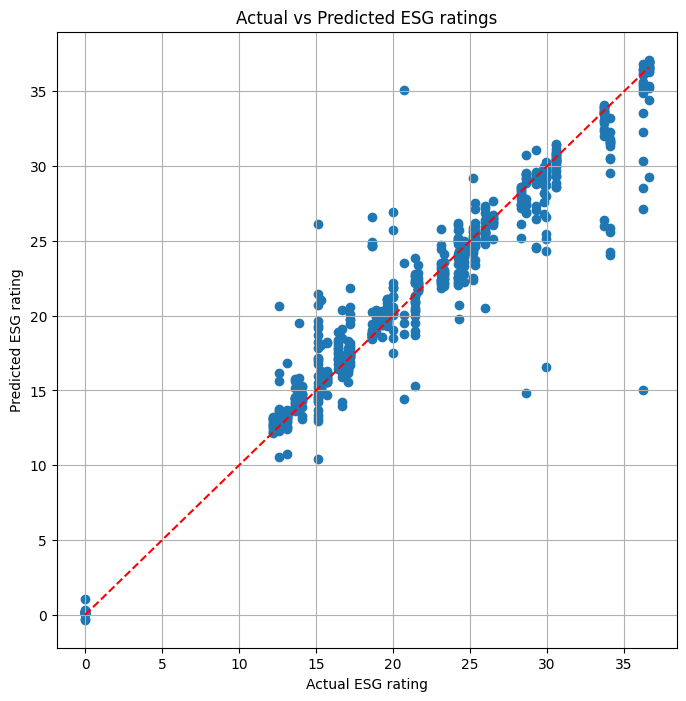

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted ESG ratings')
plt.xlabel('Actual ESG rating')
plt.ylabel('Predicted ESG rating')
plt.grid(True)
plt.show()

# Saving the model

In [24]:
best_xgb.save_model('/content/drive/MyDrive/vnp-project/models/xgb_esg_model.json')